In [1]:
import pathlib
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [3]:
folder = pathlib.Path('./../dataset/seq50rect3')
images = list(folder.iterdir())
images = [cv2.imread(str(img), cv2.IMREAD_GRAYSCALE) for img in images]

In [13]:
import config

In [16]:
camera_matrix = np.array(
    [[config.CAMERA_CALIBRATION[0], 0, config.CAMERA_CALIBRATION[2]],
    [0, config.CAMERA_CALIBRATION[1], config.CAMERA_CALIBRATION[3]],
    [0, 0, 1]]
)

In [4]:
img1 = images[0] # queryImage
img2 = images[1] # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)
# Apply ratio test
good = []

for m, n in matches:
    if m.distance < 0.25*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

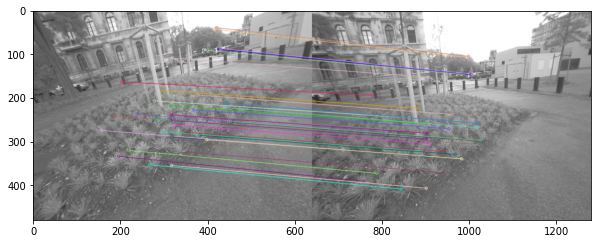

(<matplotlib.image.AxesImage at 0x232abdba760>, None)

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.dpi = 1200
plt.imshow(img3), plt.show()

In [6]:
pts_im1 = [kp1[m[0].queryIdx].pt for m in good]
pts_im1 = np.array(pts_im1, dtype=np.float32).T
pts_im2 = [kp2[m[0].trainIdx].pt for m in good]
pts_im2 = np.array(pts_im2, dtype=np.float32).T

In [7]:
retval, mask = cv2.findHomography(pts_im1.T, pts_im2.T, cv2.RANSAC, 50.0)

In [8]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)], True, 255, 3, cv2.LINE_AA)

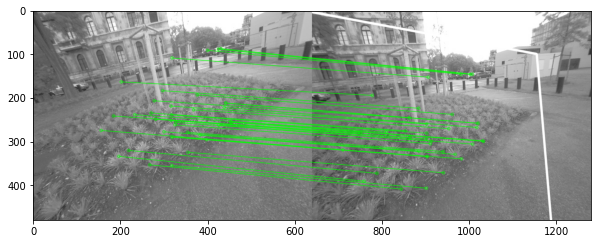

(<matplotlib.image.AxesImage at 0x232abbfd820>, None)

In [12]:
# img1c = cv2.imread()
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
good = np.reshape(np.array(good), -1)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3, 'gray'), plt.show()

In [174]:
# https://stackoverflow.com/questions/31431047/3d-reconstruction-from-two-calibrated-cameras-where-is-the-error-in-this-pipel
# normalised coordinates ? also what to do with normals in decomposeHomographyMat?

def choose_points(src_pts, dst_pts, choices):
    if choices > src_pts.shape[0]:
        raise Exception(f'Invalid number of choices, max: {src_pts.shape[0]}')
    
    corrs = []
    choices = np.random.choice(src_pts.shape[0], size=choices, replace=False)
    for i in choices:
        corrs.append((src_pts[i], dst_pts[i]))
        # normalize points ?
    return np.array(corrs)

    
def triangulate_points(camera_matrix, src_pts, dst_pts, rot, trans, normals, choices=10):
    # creates projection matrix for the reference (first) camera
    rt_mat_orig = np.hstack((np.identity(3), np.zeros(3)[np.newaxis].T))
    projection_mat_orig = np.dot(camera_matrix, rt_mat_orig)
    
    solutions = []
    points = choose_points(src_pts, dst_pts, choices)
    for idx_solution in range(len(rot)):
        # creates projection matrix for the second camera
        rt_mat_2nd = np.hstack((rot[idx_solution], trans[idx_solution]))
        projection_mat_2nd = np.dot(camera_matrix, rt_mat_2nd)
        
        pts_3d = cv2.triangulatePoints(
            projection_mat_orig, projection_mat_2nd, points[:, 0], points[:, 1]
        )
        uhomo_pts_3d = np.array([pts_3d[0]/pts_3d[3], pts_3d[1]/pts_3d[3], pts_3d[2]/pts_3d[3]])
        if np.any(uhomo_pts_3d[2, :] < 0):
            continue  # invalid solution, point is behind the camera

        solutions.append({
            'pts_list': pts_3d.T,
            'pro_mat': projection_mat,
            't_vec': trans[idx_solution],
            'rt_mat': rt_mat
        })
    if len(solutions) > 1:
        choices += 2
        return triangulate_points(
            camera_matrix, src_pts, dst_pts, rot, trans, normals, choices=choices
        )
    if not solutions:
        raise Exception('Couldnt find solution to point triangulation')
    return solutions[0]
    
    

In [176]:
_, rot, trans, normals = cv2.decomposeHomographyMat(M, camera_matrix)
solutions = triangulate_points(camera_matrix, src_pts, dst_pts, rot, trans, normals, choices=2)

In [181]:
camera_1st = np.array([0, 0, 0])
camera_2nd = (camera_1st + solutions['t_vec'].T)[0]

In [ ]:
# estimating the camera pose